In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Prepare lists to store the flattened images and labels
flattened_images = []
labels = []

# Loop over each file in the directory
for filename in os.listdir("Images"):
    file_path = os.path.join("Images", filename)
    with Image.open(file_path) as img:
        flattened_img = np.array(img).flatten()
        flattened_images.append(flattened_img)
        # Extract the class label from the filename
        # Example filename: yaleB01_P00A+000E+00.png
        # Extract '01' from 'yaleB01', which is the subject ID
        label = filename.split('_')[0]
        label = label[5:7]
        labels.append(label)

# Convert lists to numpy arrays
image_matrix = np.array(flattened_images)
label_array = np.array(labels)

print("Image matrix shape:", image_matrix.shape)
print("Labels array shape:", label_array.shape)

Image matrix shape: (2414, 32256)
Labels array shape: (2414,)


There are 38 subjects and 2414 images in the dataset (about 64 images per subject with some subjects having slightly fewer than 64), each flattened to a 1D array of length 32256 (192x168). The labels array contains the subject ID for each image.

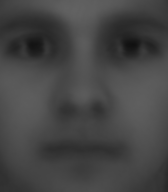

In [4]:
# Compute the mean face
mean_face = np.mean(image_matrix, axis=0)
std = np.std(image_matrix, axis=0)

# Reshape the mean face back to the original dimensions for visualization
original_dimensions = (192, 168)
mean_face_image = mean_face.reshape(original_dimensions)
std_image = std.reshape(original_dimensions)


# Convert the mean face back to an image (ensure the pixel values are scaled properly)
mean_face_image = Image.fromarray(np.uint8(mean_face_image))
display(mean_face_image)

This is the mean face of the dataset. It represents the average face of all the subjects in the dataset. We will subtract this mean face from each image to center the dataset.

In [5]:
image_matrix_0 = (image_matrix - mean_face) / std

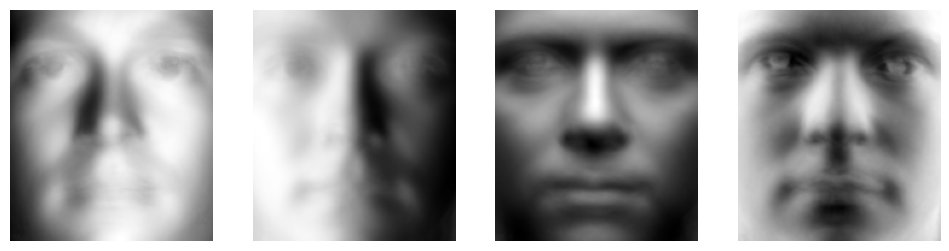

In [14]:
# Keep 95% of the variance
variance_percentage = 0.95

# Initialize PCA model
pca = PCA(n_components=variance_percentage)

# Fit PCA on the centered data
pca.fit(image_matrix_0)

# Transform the data into principal components
transformed_data = pca.transform(image_matrix_0)

# Visualize the first few eigenfaces
eigenfaces = pca.components_.reshape(-1, original_dimensions[0], original_dimensions[1])

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.axis('off')
plt.show()

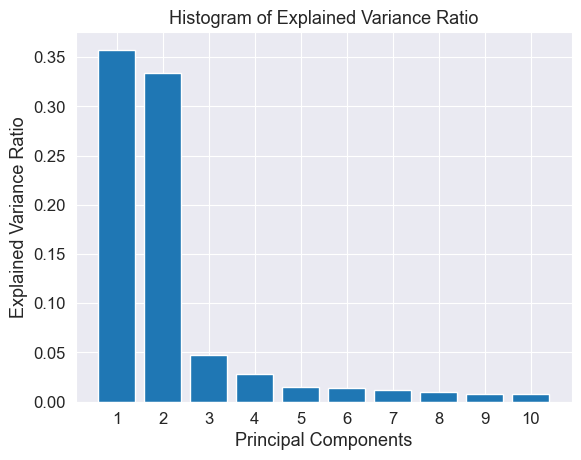

In [15]:
explained_variance = pca.explained_variance_ratio_[:10]
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Histogram of Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))  # Adding 1 to include all components in the axis
plt.show()

In [16]:
print(f"Tranformed data shape: {transformed_data.shape}")
print(f"Eigenfaces shape: {eigenfaces.shape}")
print(f"Number of components: {pca.n_components_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_[:10]}")

Tranformed data shape: (2414, 73)
Eigenfaces shape: (73, 192, 168)
Number of components: 73
Explained variance ratio: [0.35753173 0.3337617  0.04791917 0.02802229 0.01472698 0.01393343
 0.01170699 0.01037753 0.00825205 0.00805508]


The transformed data has a shape of (2414, 63), which means each image is now represented by 63 principal components. The eigenfaces have a shape of (63, 192, 168), representing the first 63 principal components as images. The PCA model has reduced the dimensionality of the data from 32256 to 63 while retaining 95% of the variance. Explained variance ratio shows the percentage of variance explained by each component. Only the first 10 components are shown here.

In [17]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Assuming 'image_matrix_0' is your feature matrix and 'label_array' contains corresponding labels
# Convert labels to numeric format
label_encoder = LabelEncoder()
labels_numeric = label_encoder.fit_transform(label_array)

# Choose specific labels to display
selected_labels = ['10', '18', '35']
selected_indices = [i for i, label in enumerate(label_array) if label in selected_labels]
selected_data = image_matrix_0[selected_indices]
selected_labels_numeric = labels_numeric[selected_indices]

# Perform PCA
pca_3 = PCA(n_components=3)
X_pca = pca_3.fit_transform(selected_data)

# Create a Plotly 3D scatter plot with separate traces for each selected label
fig = go.Figure()

for label in selected_labels:
    # Get indices for the current label
    indices = [i for i, l in enumerate(label_array[selected_indices]) if l == label]
    # Add a trace for the current label
    fig.add_trace(go.Scatter3d(
        x=X_pca[indices, 0],
        y=X_pca[indices, 1],
        z=X_pca[indices, 2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.8,
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        name= "ID: " + label  # This sets the legend entry for this trace
    ))

# Update plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Comp. 1',
        yaxis_title='Principal Comp. 2',
        zaxis_title='Principal Comp. 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    legend=dict(
        x=0.5,  # Center the legend horizontally
        y=1.1,  # Position the legend above the top of the plot
        xanchor='center',  # Center-align the legend's horizontal position
        orientation='h',  # Horizontal orientation of the legend
        font = dict(size=18)
    )
)

# Show plot
fig.show()

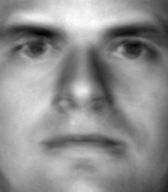

In [28]:
n = 50
k = 200
first_n_components = pca.components_[:n]  # shape will be (n, img_height * img_width)
first_n_eigenfaces = eigenfaces[:n]  # shape will be (n, img_height * img_width)
first_image_scores = transformed_data[k, :n]  # k'th image, first n scores

reconstructed_image = np.zeros(original_dimensions)

# Apply weights and sum
for i in range(n):
    reconstructed_image += first_image_scores[i] * eigenfaces[i]

# Add the mean face to get the final reconstructed image
reconstructed_image = reconstructed_image*std_image + mean_face_image

# Apply min-max normalization to scale pixel values to 0-255 for display
min_val = np.min(reconstructed_image)
max_val = np.max(reconstructed_image)
reconstructed_image_normalized = 255 * (reconstructed_image - min_val) / (max_val - min_val)
reconstructed_image_normalized = Image.fromarray(np.uint8(reconstructed_image_normalized))

# Display the reconstructed image directly in the notebook
display(reconstructed_image_normalized)

In [30]:
# Unique classes in the dataset
unique_classes = np.unique(labels)

# Initialize lists to hold the split results
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

train_indices = []
test_indices = []

for cls in unique_classes:
    indices = np.where(label_array == cls)[0]
    train_idx, test_idx = train_test_split(indices, train_size=0.75, random_state=42, shuffle=True)
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

# Use the indices to split both the original and transformed datasets
X_train_pca = transformed_data[train_indices]
X_test_pca = transformed_data[test_indices]
y_train = label_array[train_indices]
y_test = label_array[test_indices]

In [31]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return classifier

Evaluating PCA-Reduced Data:


C:\Users\korki\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

          01       1.00      0.94      0.97        16
          02       0.94      1.00      0.97        16
          03       0.89      1.00      0.94        16
          04       1.00      0.94      0.97        16
          05       1.00      1.00      1.00        16
          06       1.00      1.00      1.00        16
          07       0.94      0.94      0.94        16
          08       1.00      1.00      1.00        16
          09       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        16
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       0.93      0.93      0.93        15
          15       1.00      0.81      0.90        16
          16       1.00      0.88      0.93        16
          17       1.00      0.94      0.97        16
          18       1.00      0.94      0.97

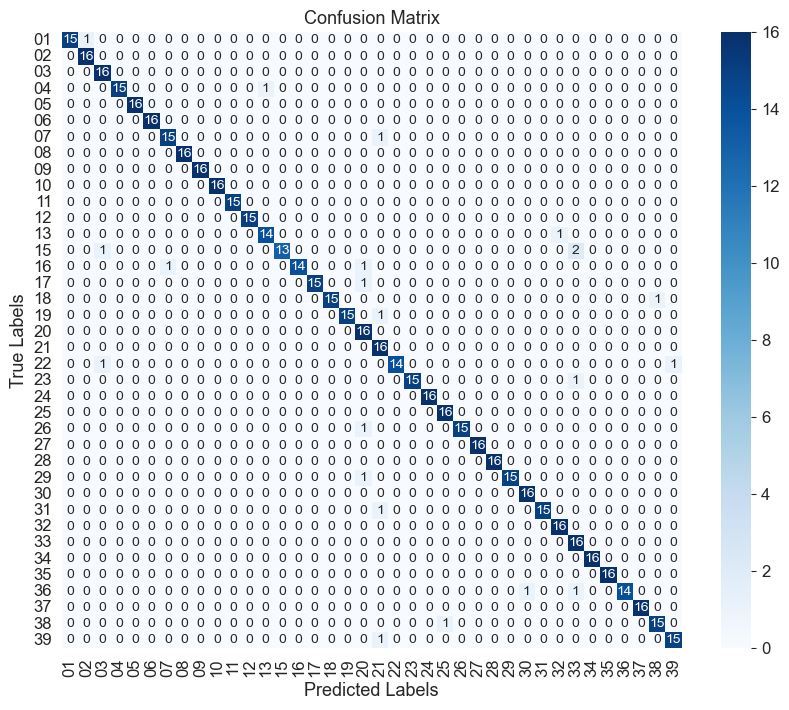

LogisticRegression(C=0.005, max_iter=500)

In [32]:
# Classifier for PCA-reduced data
log_reg_pca = LogisticRegression(max_iter=500, C=0.005)
print("Evaluating PCA-Reduced Data:")
evaluate_model(log_reg_pca, X_train_pca, y_train, X_test_pca, y_test)

Evaluation on Original Data with SVM:
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

          01       0.94      1.00      0.97        16
          02       1.00      1.00      1.00        16
          03       0.94      1.00      0.97        16
          04       1.00      0.94      0.97        16
          05       1.00      1.00      1.00        16
          06       1.00      1.00      1.00        16
          07       0.94      0.94      0.94        16
          08       1.00      1.00      1.00        16
          09       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        16
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       0.93      0.93      0.93        15
          15       1.00      0.81      0.90        16
          16       1.00      0.88      0.93        16
          17       1.00      0.94      0.97        16
     

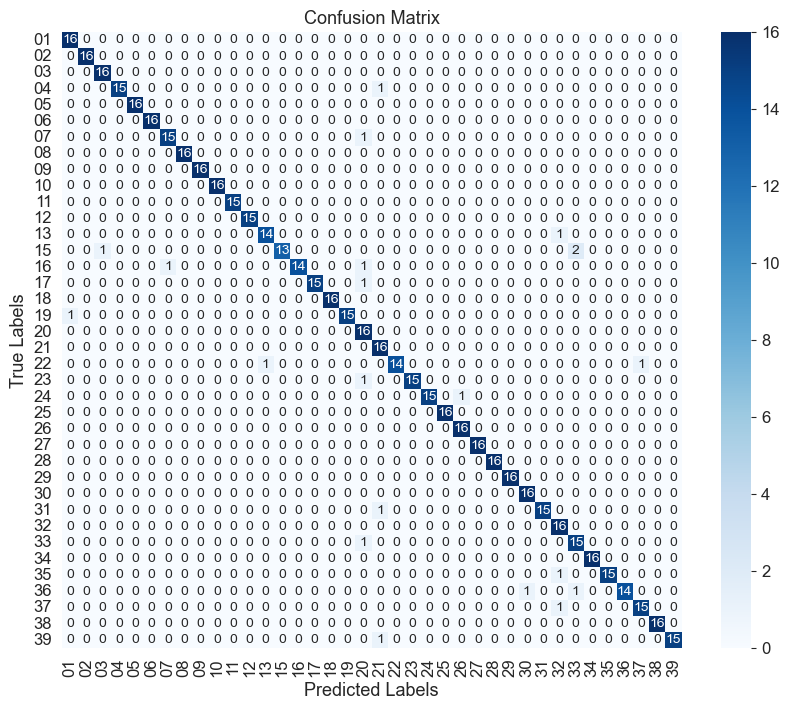

SVC(C=0.001, kernel='linear', random_state=42)

In [33]:
svm = SVC(kernel='linear', random_state=42, C=0.001)
print("Evaluation on Original Data with SVM:")
evaluate_model(svm, X_train_pca, y_train, X_test_pca, y_test)